In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('paper')

In [2]:
import numpy as np
import scipy.constants as sc

class simple_disk:
    """
    Simple disk structure to explore kinematic features.
    
    The idea is to be able to explore how localized kinematic features
    look in residual maps and how they would look in the channels.
    """
    
    def __init__(self, inc, PA, x0=0.0, y0=0.0, z0=0.0, psi=0.0,
                 z1=0.0, phi=0.0, dist=100.0, mstar=1.0, radius=3.0):        
        
        # Define the coordinate axes in [arcsec].
        
        self.xaxis = np.linspace(-radius, radius, 500)[::-1]
        self.yaxis = np.linspace(-radius, radius, 500)
        
        # Calculate the projected pixel coordinates in [au].

        self.dist = dist
        self.inc = inc
        self.PA = PA
        coords = self.disk_coords(x0=x0, y0=y0, inc=inc, PA=PA, z0=z0,
                                  psi=psi, z1=z1, phi=phi)
        self.rvals = coords[0] * self.dist
        self.tvals = coords[1]
        self.zvals = coords[2] * self.dist
        self.xvals = self.rvals * np.cos(self.tvals)
        self.yvals = self.rvals * np.sin(self.tvals)
        
        # Calculate the background velocity field in [m/s].
        # Note that we don't have a systemic velocity.
        
        self.mstar = mstar
        
    @property
    def v_kep(self):
        """
        Calculate the Keplerian velocity field, including vertical shear.
        """
        vkep2 = sc.G * self.mstar * 1.988e30 * self.rvals
        vkep2 /= np.hypot(self.rvals, self.zvals)**3.0
        vkep = np.sqrt(vkep2 / sc.au)
        return vkep * np.cos(self.tvals) * np.sin(np.radians(self.inc))
    
    def azimuthal_flip(self, v0, r0, t0, dr=0.3, dt=0.5, r_split=None, t_split=None):
        """
        Projected azimuthal velocity flip.
        TODO: Check the direction of this (based on sign of inclination).
        """
        r_split = 0.1 * r0 if r_split is None else r_split
        t_split = dt if t_split is None else t_split
        vr_p = v0 * simple_disk.gaussian(self.tvals, (t0 - 0.5 * t_split), dt) 
        vr_p *= simple_disk.gaussian(self.rvals, (r0 - 0.5 * r_split) * self.dist, dr * self.dist)
        vr_n = -v0 * simple_disk.gaussian(self.tvals, (t0 + 0.5 * t_split), dt) 
        vr_n *= simple_disk.gaussian(self.rvals, (r0 + 0.5 * r_split) * self.dist, dr * self.dist)
        return (vr_n + vr_p) * np.cos(self.tvals) * np.sin(np.radians(self.inc))
    
    def radial_flip(self, v0, r0, t0, dr=0.3, dt=0.5, r_split=None, t_split=None):
        """
        Projected radial velocity flip.
        TODO: Check the direction of this (based on sign of inclination).
        """
        r_split = 0.0 if r_split is None else r_split
        t_split = 0.1 if t_split is None else t_split
        vr_p = v0 * simple_disk.gaussian(self.tvals, (t0 - 0.5 * t_split), dt) 
        vr_p *= simple_disk.gaussian(self.rvals, (r0 - 0.5 * r_split) * self.dist, dr * self.dist)
        vr_n = -v0 * simple_disk.gaussian(self.tvals, (t0 + 0.5 * t_split), dt) 
        vr_n *= simple_disk.gaussian(self.rvals, (r0 + 0.5 * r_split) * self.dist, dr * self.dist)
        return (vr_n + vr_p) * np.sin(self.tvals) * np.sin(np.radians(self.inc))

    def vertical_flow(self, v0, r0, t0, dr=0.3, dt=0.5):
        """
        Projected vertical velocity.
        
        Args:
            v0 (float): Velocity in [m/s] of the flow.
            r0 (float): Radial distance in [arcsec] of the flow center.
            t0 (float): Polar angle in [radians] of the flow center.
            dr (float): Radiual width of the flow in [radians].
            dt (float): Polar width of the flow in [radians].
        """
        v0 *= simple_disk.gaussian(self.rvals, r0 * self.dist, dr * self.dist)
        v0 *= simple_disk.gaussian(self.tvals, t0, dt)
        return v0 * np.cos(np.radians(self.inc))

    def disk_coords(self, x0=0.0, y0=0.0, inc=0.0, PA=0.0, z0=0.0, psi=0.0,
                    z1=0.0, phi=0.0, frame='cylindrical'):
        r"""
        Get the disk coordinates given certain geometrical parameters and an
        emission surface. The emission surface is parameterized as a powerlaw
        profile:

        .. math::

            z(r) = z_0 \times \left(\frac{r}{1^{\prime\prime}}\right)^{\psi} +
            z_1 \times \left(\frac{r}{1^{\prime\prime}}\right)^{\varphi}

        Where both ``z0`` and ``z1`` are given in [arcsec]. For a razor thin
        disk, ``z0=0.0``, while for a conical disk, as described in `Rosenfeld
        et al. (2013)`_, ``psi=1.0``. Typically ``z1`` is not needed unless the
        data is exceptionally high SNR and well spatially resolved.

        It is also possible to override this parameterization and directly
        provide a user-defined ``z_func``. This allow for highly complex
        surfaces to be included. If this is provided, the other height
        parameters are ignored.

        .. _Rosenfeld et al. (2013): https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R/

        Args:
            x0 (Optional[float]): Source right ascension offset [arcsec].
            y0 (Optional[float]): Source declination offset [arcsec].
            inc (Optional[float]): Source inclination [deg].
            PA (Optional[float]): Source position angle [deg]. Measured
                between north and the red-shifted semi-major axis in an
                easterly direction.
            z0 (Optional[float]): Aspect ratio at 1" for the emission surface.
                To get the far side of the disk, make this number negative.
            psi (Optional[float]): Flaring angle for the emission surface.
            z1 (Optional[float]): Aspect ratio correction term at 1" for the
                emission surface. Should be opposite sign to ``z0``.
            phi (Optional[float]): Flaring angle correction term for the
                emission surface.
            frame (Optional[str]): Frame of reference for the returned
                coordinates. Either ``'polar'`` or ``'cartesian'``.

        Returns:
            Three coordinate arrays, either the cylindrical coordaintes,
            ``(r, theta, z)`` or cartestian coordinates, ``(x, y, z)``,
            depending on ``frame``.
        """

        # Check the input variables.

        frame = frame.lower()
        if frame not in ['cylindrical', 'cartesian']:
            raise ValueError("frame must be 'cylindrical' or 'cartesian'.")

        # Define the emission surface function. Use the simple double
        # power-law profile.

        def z_func(r):
            z = z0 * np.power(r, psi) + z1 * np.power(r, phi)
            if z0 >= 0.0:
                return np.clip(z, a_min=0.0, a_max=None)
            return np.clip(z, a_min=None, a_max=0.0)

        # Calculate the pixel values.
        r, t, z = self._get_flared_coords(x0, y0, inc, PA, z_func)
        if frame == 'cylindrical':
            return r, t, z
        return r * np.cos(t), r * np.sin(t), z

    
    @staticmethod
    def _rotate_coords(x, y, PA):
        """Rotate (x, y) by PA [deg]."""
        x_rot = y * np.cos(np.radians(PA)) + x * np.sin(np.radians(PA))
        y_rot = x * np.cos(np.radians(PA)) - y * np.sin(np.radians(PA))
        return x_rot, y_rot

    
    @staticmethod
    def _deproject_coords(x, y, inc):
        """Deproject (x, y) by inc [deg]."""
        return x, y / np.cos(np.radians(inc))

    
    def _get_cart_sky_coords(self, x0, y0):
        """Return caresian sky coordinates in [arcsec, arcsec]."""
        return np.meshgrid(self.xaxis - x0, self.yaxis - y0)

    
    def _get_polar_sky_coords(self, x0, y0):
        """Return polar sky coordinates in [arcsec, radians]."""
        x_sky, y_sky = self._get_cart_sky_coords(x0, y0)
        return np.hypot(y_sky, x_sky), np.arctan2(x_sky, y_sky)

    
    def _get_midplane_cart_coords(self, x0, y0, inc, PA):
        """Return cartesian coordaintes of midplane in [arcsec, arcsec]."""
        x_sky, y_sky = self._get_cart_sky_coords(x0, y0)
        x_rot, y_rot = simple_disk._rotate_coords(x_sky, y_sky, PA)
        return simple_disk._deproject_coords(x_rot, y_rot, inc)

    
    def _get_midplane_polar_coords(self, x0, y0, inc, PA):
        """Return the polar coordinates of midplane in [arcsec, radians]."""
        x_mid, y_mid = self._get_midplane_cart_coords(x0, y0, inc, PA)
        return np.hypot(y_mid, x_mid), np.arctan2(y_mid, x_mid)

    
    def _get_flared_coords(self, x0, y0, inc, PA, z_func):
        """Return cylindrical coordinates of surface in [arcsec, radians]."""
        x_mid, y_mid = self._get_midplane_cart_coords(x0, y0, inc, PA)
        r_tmp, t_tmp = np.hypot(x_mid, y_mid), np.arctan2(y_mid, x_mid)
        for _ in range(10):
            y_tmp = y_mid + z_func(r_tmp) * np.tan(np.radians(inc))
            r_tmp = np.hypot(y_tmp, x_mid)
            t_tmp = np.arctan2(y_tmp, x_mid)
        return r_tmp, t_tmp, z_func(r_tmp)
    
    @property
    def extent(self):
        return [self.xaxis[0], self.xaxis[-1], self.yaxis[0], self.yaxis[-1]]
    
    @staticmethod
    def gaussian(x, x0, dx, A=1.0):
        return A * np.exp(-((x-x0)/dx)**2)
        

In [3]:
test = simple_disk(inc=-47.3, PA=312.0, z0=0.3, psi=1.25)
test = simple_disk(inc=47.3, PA=312.0)

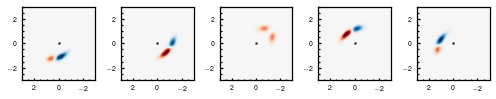

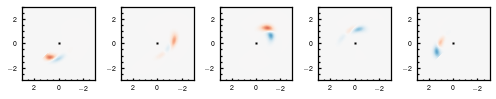

In [4]:
fig, axs = plt.subplots(ncols=5, figsize=(7, 1.5))

for ax, t0 in zip(axs, np.linspace(-0.75 * np.pi, 0.75 * np.pi, 5)):
    im = ax.imshow(test.radial_flip(v0=4000., r0=1.5, t0=t0), origin='lower', extent=test.extent,
                   cmap='RdBu', vmax=400, vmin=-400)
    #plt.colorbar(im, ax=ax)
    ax.scatter(0, 0, marker='x', color='k', s=3, lw=1.0)
plt.tight_layout()


fig, axs = plt.subplots(ncols=5, figsize=(7, 1.5))

for ax, t0 in zip(axs, np.linspace(-0.75 * np.pi, 0.75 * np.pi, 5)):
    im = ax.imshow(test.azimuthal_flip(v0=400., r0=1.5, t0=t0), origin='lower', extent=test.extent,
                   cmap='RdBu', vmax=400, vmin=-400)
    #plt.colorbar(im, ax=ax)
    ax.scatter(0, 0, marker='x', color='k', s=3, lw=1.0)
plt.tight_layout()
